In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
train_dataset = MNIST(True)
test_dataset = MNIST(False)

In [4]:
train_x, train_y = train_dataset.data.numpy(), train_dataset.targets
test_x, test_y = test_dataset.data.numpy(), test_dataset.targets
train_y2 = to_one_hot(train_y, 10).numpy()
test_y2 = to_one_hot(test_y, 10).numpy()
train_y = train_y.numpy()
test_y = test_y.numpy()

In [57]:
train_data = FromNumpy(train_x[:, None, :, :], [train_y2, train_y], batch_size=256)
test_data = FromNumpy(test_x[:, None, :, :], [test_y2, test_y], batch_size=256)

In [58]:
class Auxiliary(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        self.store = None
    
    def forward(self, x):
        # Store the result
        # Return the origin value
        self.store = self.f(x)
        return x 

In [59]:
class Reg(nn.Module):
    def __init__(self, f, group, get='weight'):
        super().__init__()
        self.f = f
        self.get = get
        self.reg_store = None
        self.reg_group = group
        
    def forward(self, x):
        out = self.f(x)
        if self.get == 'weight':
            self.reg_store = self.f.weight
        elif self.get == 'out':
            self.reg_store = out
        elif self.get == 'in':
            self.reg_stroe = x
        return out
    

In [60]:
class Orthogonal(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, w1, w2):
        return self.alpha * torch.matmul(w1, w2.t()).abs().mean()

In [61]:
model = builder([
    nn.Conv2d(1, 20, 5, 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(20, 50, 5, 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    Flatten(),
    Auxiliary(builder([
        Reg(nn.Linear(4*4*50, 128), 'orth'),
        nn.ReLU(),
        Reg(nn.Linear(128, 10), 'orth2'),
        nn.Sigmoid()
    ])),
    Reg(nn.Linear(4*4*50, 128), 'orth'),
    nn.ReLU(),
    Reg(nn.Linear(128, 10), 'orth2'),
    nn.Softmax(1)
])

In [62]:
runner = Runner(model, train_data, test_data, 'adam', ['bce', 'll'], reg_fn={'orth': Orthogonal(), 'orth2': Orthogonal()})

In [63]:
runner.fit(3, cycle='sc')

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1*        0.2140        9.7579        0.0261        9.9572    


    2         0.0235        9.9640        0.0218        9.9613    


    3         0.0203        9.9692        0.0216        9.9636    


In [64]:
runner.fit(6, cycle='cycle')

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1         0.0208        9.9670        0.0179        9.9719    


    2         0.0166        9.9747        0.0148        9.9756    


    3         0.0087        9.9881        0.0134        9.9782    


    4         0.0111        9.9833        0.0149        9.9770    


    5         0.0066        9.9908        0.0126        9.9803    


    6         0.0038        9.9966        0.0121        9.9813    


    7         0.0062        9.9913        0.0145        9.9764    


    8         0.0042        9.9946        0.0140        9.9801    


    9         0.0023        9.9987        0.0136        9.9808    


    10        0.0018        9.9995        0.0132        9.9816    


    11        0.0030        9.9972        0.0167        9.9776    


    12        0.0026        9.9977        0.0162        9.9815    


    13        0.0015        9.9996        0.0139        9.9816    


    14        0.0012        9.9999        0.0145        9.9818    


    15        0.0011        9.9999        0.0141        9.9816    


    16        0.0012        9.9998        0.0148        9.9810    


    17        0.0011        9.9999        0.0153        9.9806    


    18        0.0009       10.0000        0.0151        9.9809    


    19        0.0008       10.0000        0.0163        9.9815    


    20        0.0007       10.0000        0.0156        9.9815    


    21        0.0007       10.0000        0.0152        9.9813    


In [65]:
model = runner.model

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[5.6194e-08, 5.6787e-06, 9.9990e-01, 8.2409e-06, 1.5240e-06, 4.3496e-11,
         1.5022e-12, 6.1610e-07, 5.0883e-10, 1.4469e-09]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[6.1715e-13, 1.2035e-04, 9.9999e-01, 1.0767e-08, 2.7451e-08, 1.1210e-14,
         1.8716e-11, 1.4722e-08, 6.6224e-11, 1.6247e-11]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[3.4680e-20, 6.8346e-10, 9.9988e-01, 8.8727e-14, 4.1835e-14, 4.8757e-25,
         2.8115e-23, 9.0700e-15, 3.3697e-20, 2.3508e-20]], device='cuda:0',
       grad_fn=<MulBackward0>)


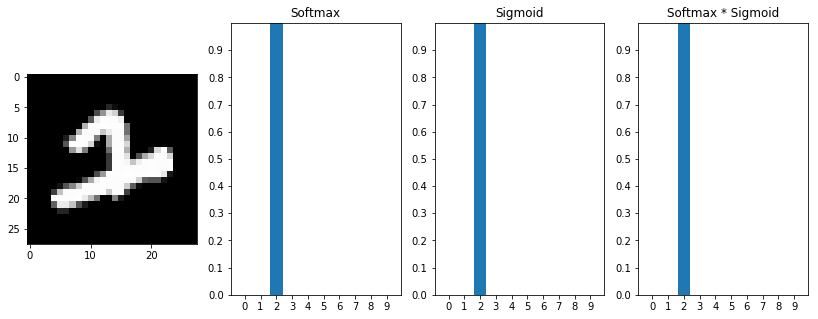

In [102]:
data = next(iter(test_data))
x = data[0][0]
x = x[None, :, :, :]
print(data[2][0])

x = x.permute(0,1,3,2)

out1 = model(x.cuda())
out2 = get_aux_out(model)[0]
print(out1)
print(out2)
print((out1*out2))

import matplotlib.pyplot as plt
fig, arr = plt.subplots(1, 4, figsize=(14, 5))
arr[0].imshow(x.numpy()[0][0], cmap='gray')
arr[1].set_title('Softmax')
arr[1].set_xticks(range(10))
arr[1].set_yticks([i/10 for i in range(10)])
arr[1].set_ylim(0, 1)
arr[1].bar(range(10), out1.detach().cpu().numpy()[0])
arr[2].set_title('Sigmoid')
arr[2].set_xticks(range(10))
arr[2].set_yticks([i/10 for i in range(10)])
arr[2].set_ylim(0, 1)
arr[2].bar(range(10), out2.detach().cpu().numpy()[0])
arr[3].set_title('Softmax * Sigmoid')
arr[3].set_xticks(range(10))
arr[3].set_yticks([i/10 for i in range(10)])
arr[3].set_ylim(0, 1)
arr[3].bar(range(10), ((out1*out2)).detach().cpu().numpy()[0])
plt.show()
